# Nonparametric inference changes in spm1d v0.4.50

(2025-06-03)

A [recent discussion](https://github.com/0todd0000/spm1d/issues/307) in the **spm1d** support forum uncovered a bug in nonparametric inference. (Thank you very much to Jeremy for discovering this bug!!)

The bug affects both the Python and MATLAB versions of **spm1d** for all versions prior to v0.4.50.

The bug affects the following procedures:

- `spm1d.stats.nonparam.ttest`
- `spm1d.stats.nonparam.ttest_paired`
- `spm1d.stats.nonparam.ttest2`
- `spm1d.stats.nonparam.regress`
- `spm1d.stats.nonparam.ci_onesample`
- `spm1d.stats.nonparam.ci_pairedsample`
- `spm1d.stats.nonparam.ci_twosample`


**Note**: Although the bug affects several procedures, its effects are expected to be large only for a relatively specific scenario involving all of the following simultaneously:

- a small total sample size, less than about $N$=10
- two-tailed inference, and
- large effects in both the positive and negative direction


Below is a description of the bug and a demonstration of its resolution in spm1d v0.4.50.

<br>
<br>

___

## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spm1d

Before starting verify that you have **spm1d** version 0.4.50 or later:

In [2]:
print( spm1d.__version__ )

0.4.50


Note that the `spm1d.stats.nonparam` subpackage has been rewritten. If you wish to replicate previous versions' results please use the `spm1d.stats.nonparam_old` package which retains the original code.

In [3]:
import spm1d.stats.nonparam_old

<br>
<br>

___

## Dataset

Let's load an example dataset that demonstrates the problem:

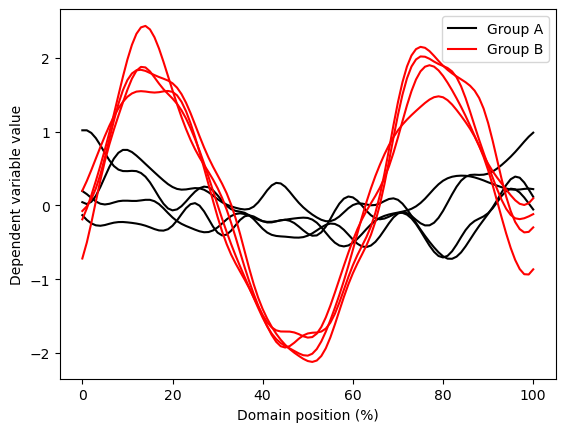

In [4]:
dataset = spm1d.data.uv1d.t2.SmallSampleLargePosNegEffects()
y0,y1   = dataset.get_data()

plt.figure()
ax = plt.axes()
h0 = ax.plot( y0.T, color='k' )[0]
h1 = ax.plot( y1.T, color='r' )[0]
ax.set_xlabel('Domain position (%)')
ax.set_ylabel('Dependent variable value')
ax.legend([h0,h1],['Group A', 'Group B'])
plt.show()


These data are simulated as per the [forum example](https://github.com/0todd0000/spm1d/issues/307#issuecomment-2922313177) provided by Dr. Jeremy Eekhoff. This dataset meets two of the aforementioned bug criteria:

- a small total sample size, less than about $N$=10
- large effects in both the positive and negative direction

The third criterion (two-tailed inference) is demonstrated below.

This dataset can be replicated in Python using the `gen_data` function below with `n=4`. The `gen_data` function is defined for arbitrary `n` so that effects of `n` can be subsequently considered.

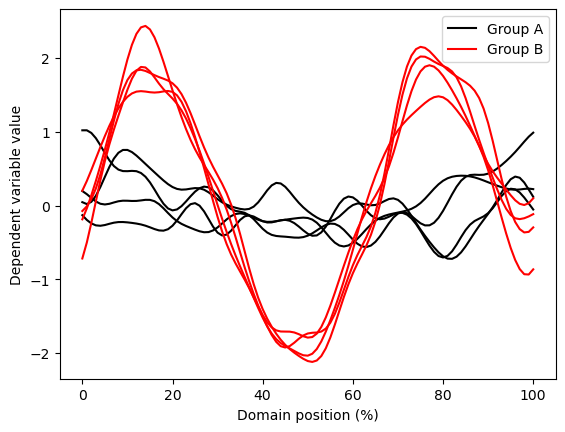

In [5]:
def gen_data(n=4):
    y0 = np.random.randn(n, 101)
    y1 = np.random.randn(n, 101) + 2*np.sin( np.linspace(0,10,101) )
    y0 = spm1d.util.smooth(y0, 8)
    y1 = spm1d.util.smooth(y1, 8)
    return y0, y1

np.random.seed(0)
y0,y1 = gen_data(n=4)

plt.figure()
ax = plt.axes()
h0 = ax.plot( y0.T, color='k' )[0]
h1 = ax.plot( y1.T, color='r' )[0]
ax.set_xlabel('Domain position (%)')
ax.set_ylabel('Dependent variable value')
ax.legend([h0,h1],['Group A', 'Group B'])
plt.show()


<br>
<br>

___

## Bug description

In **spm1d** versions prior to v0.4.50, nonparametric inference yielded an odd critical threshold for this scenario. The critical threshold "zstar (nonparam old)" in the figure below is substantially different from both the parametric threshold and the new nonparametric threshold.

zstar (param):         6.05234
zstar (nonparam):      6.18787
zstar (nonparam old):  10.15535


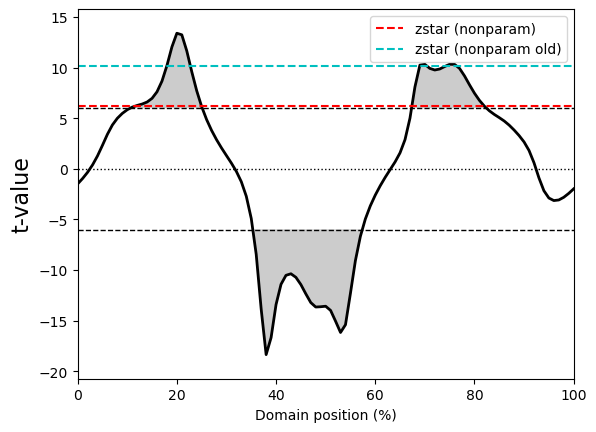

In [6]:

two_tailed = True
niter = -1

t     = spm1d.stats.ttest2(y1, y0, equal_var=True).inference(0.05, two_tailed=two_tailed)
tn    = spm1d.stats.nonparam.ttest2(y1, y0).inference(0.05, iterations=niter, two_tailed=two_tailed)
tnold = spm1d.stats.nonparam_old.ttest2(y1, y0).inference(0.05, iterations=niter, two_tailed=two_tailed)

print( f'zstar (param):         {t.zstar:.5f}')
print( f'zstar (nonparam):      {tn.zstar:.5f}')
print( f'zstar (nonparam old):  {tnold.zstar:.5f}')


plt.figure()
ax = plt.axes()
t.plot(ax=ax)
ax.axhline(tn.zstar, color='r', linestyle='--', label='zstar (nonparam)')
ax.axhline(tnold.zstar, color='c', linestyle='--', label='zstar (nonparam old)')
ax.set_xlabel('Domain position (%)')
ax.set_ylabel('t-value')
ax.legend()
plt.show()


The `examine_bug` function below assembles the code from the cell above to allow us to more closely focus on the relevant parameters: the data `y0` and `y1`, and the inference tailedness: `two_tailed`.

zstar (param):         6.05234
zstar (nonparam):      6.18787
zstar (nonparam old):  10.15535


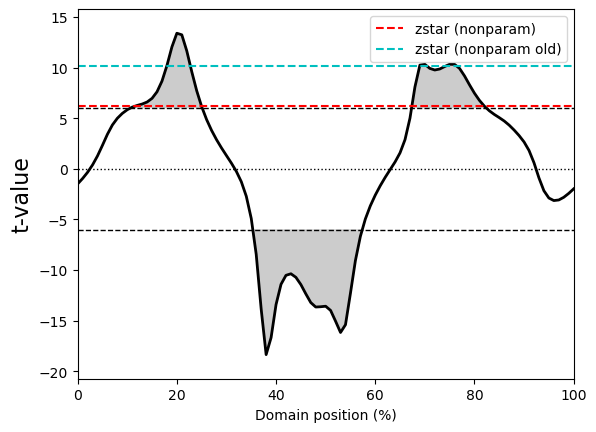

In [7]:
def examine_bug(y0, y1, two_tailed=True):
    t     = spm1d.stats.ttest2(y1, y0, equal_var=True).inference(0.05, two_tailed=two_tailed)
    tn    = spm1d.stats.nonparam.ttest2(y1, y0).inference(0.05, iterations=-1, two_tailed=two_tailed)
    tnold = spm1d.stats.nonparam_old.ttest2(y1, y0).inference(0.05, iterations=-1, two_tailed=two_tailed)
    print( f'zstar (param):         {t.zstar:.5f}')
    print( f'zstar (nonparam):      {tn.zstar:.5f}')
    print( f'zstar (nonparam old):  {tnold.zstar:.5f}')
    # plot:
    plt.figure()
    ax = plt.axes()
    t.plot(ax=ax)
    ax.axhline(tn.zstar, color='r', linestyle='--', label='zstar (nonparam)')
    ax.axhline(tnold.zstar, color='c', linestyle='--', label='zstar (nonparam old)')
    ax.set_xlabel('Domain position (%)')
    ax.set_ylabel('t-value')
    ax.legend()
    plt.show()
    
examine_bug(y0, y1, two_tailed=True)

Note that the bug persists when the order of the input arguments `y1` and `y0` is reversed:

zstar (param):         6.05234
zstar (nonparam):      6.18787
zstar (nonparam old):  10.15535


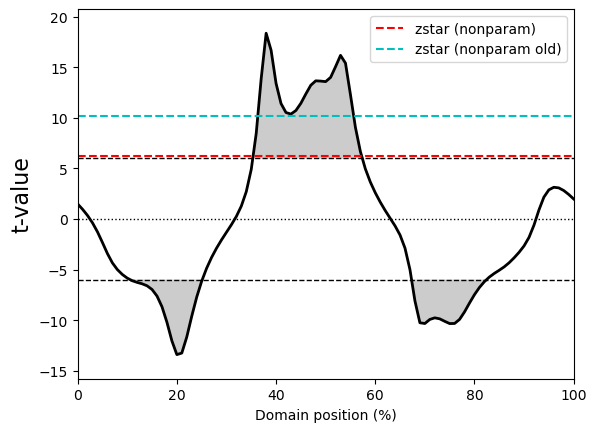

In [8]:
examine_bug(y1, y0, two_tailed=True)

However the bug disappears for one-tailed inference: 

zstar (param):         5.11688
zstar (nonparam):      4.73074
zstar (nonparam old):  4.73074


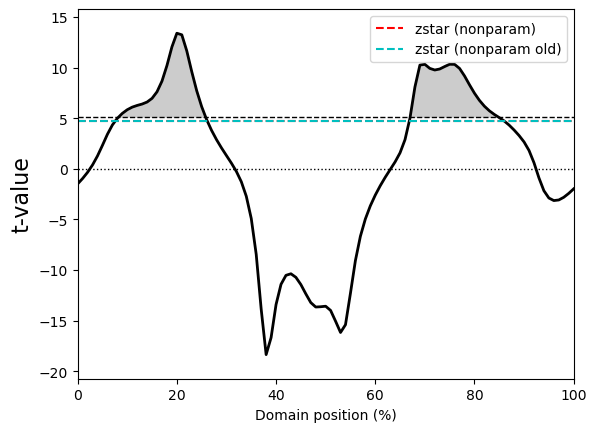

In [9]:
examine_bug(y0, y1, two_tailed=False)

As described in the [spm1d forum](https://github.com/0todd0000/spm1d/issues/307) this bug was caused by inadequate consideration of both large negative AND large postive effects in a single dataset. Specifically, when conducting two-tailed inference, the maximum **absolute** effect in permutation should be used as the basis for inference. The previous **spm1d** code failed to do this.

There are two reasons that this bug was not discovered during previous **spm1d** development:

1. During previous development only larger sample sizes were considered (`n>=6`)
1. The bug disappears for larger sample sizes (see cell below)


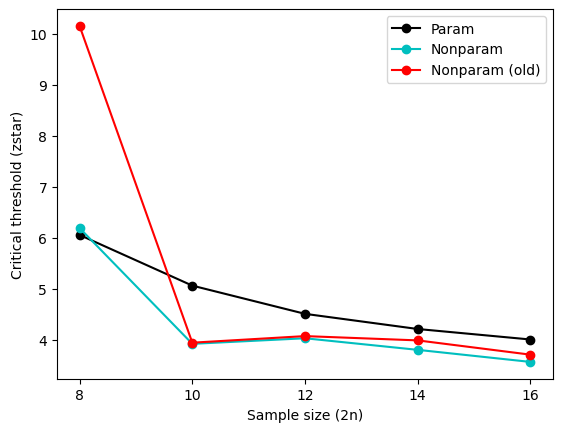

In [10]:
np.random.seed(0)
two_tailed = True
niter      = -1
ns         = np.array( [4, 5, 6, 7, 8] )
zc         = []  # critical threshold for parametric inference
zcn        = []  # critical threshold for nonparametric inference -- version 0.4.50
zcnold     = []  # critical threshold for parametric inference -- prior to version 0.4.50
for n in ns:
    y0,y1  = gen_data(n=n)
    t      = spm1d.stats.ttest2(y1, y0, equal_var=True).inference(0.05, two_tailed=two_tailed)
    tn     = spm1d.stats.nonparam.ttest2(y1, y0).inference(0.05, iterations=niter, two_tailed=two_tailed, force_iterations=True)
    tnold  = spm1d.stats.nonparam_old.ttest2(y1, y0).inference(0.05, iterations=niter, two_tailed=two_tailed, force_iterations=True)
    zc.append( t.zstar )
    zcn.append( tn.zstar )
    zcnold.append( tnold.zstar )
    

plt.figure()
ax = plt.axes()
ax.plot(2*ns, zc, 'ko-', label='Param')
ax.plot(2*ns, zcn, 'co-', label='Nonparam')
ax.plot(2*ns, zcnold, 'ro-', label='Nonparam (old)')
ax.legend()
ax.set_xticks( 2*ns )
ax.set_xlabel('Sample size (2n)')
ax.set_ylabel('Critical threshold (zstar)')
plt.show()



<br>
<br>

___

## Other scenarios

This bug is only expected to affect scenarios that meet the three criteria specified at the beginning of this notebook. For example, the bug does not appear for the  `SimulatedTwoLocalMax` dataset (see below) because there are NOT large effects in both positive and negative directions.

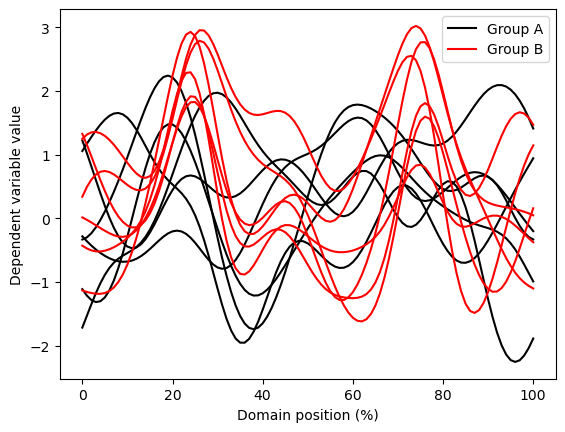

zstar (param):         4.06590
zstar (nonparam):      4.14080
zstar (nonparam old):  4.14080


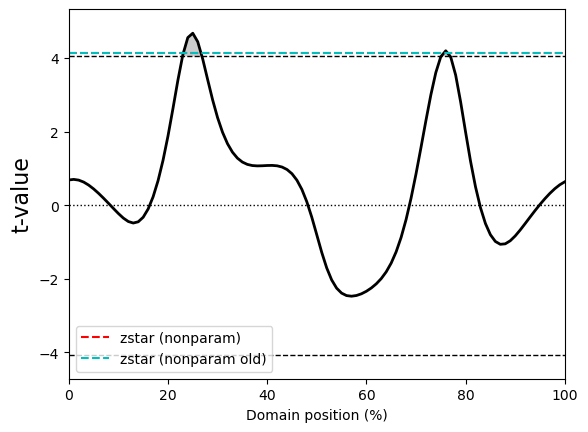

In [11]:
dataset = spm1d.data.uv1d.t2.SimulatedTwoLocalMax()
yA,yB   = dataset.get_data()


plt.figure()
ax = plt.axes()
h0 = ax.plot( yA.T, color='k' )[0]
h1 = ax.plot( yB.T, color='r' )[0]
ax.set_xlabel('Domain position (%)')
ax.set_ylabel('Dependent variable value')
ax.legend([h0,h1],['Group A', 'Group B'])
plt.show()


examine_bug(yA, yB, two_tailed=True)


The bug is absent even when reducing sample size to an extremely small value of `n=3`.

zstar (param):         8.18421
zstar (nonparam):      5.63180
zstar (nonparam old):  5.63180


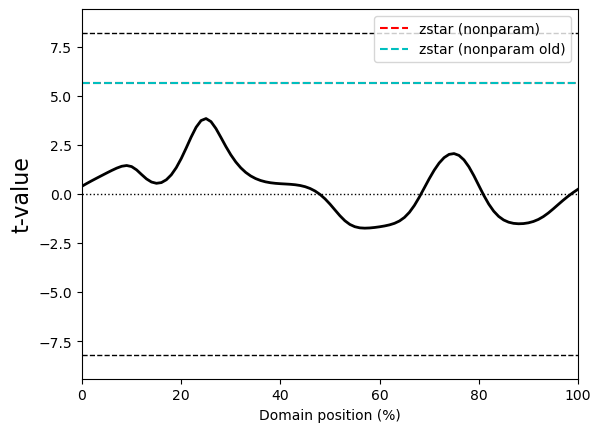

In [12]:

examine_bug(yA[:3], yB[:3], two_tailed=True)


## Summary

spm1d versions prior to v0.4.50 are subject to the nonparametric inference bug described above.

The bug is expected to only affect a relatively specific scenario involving all three of the following criteria:

- a small total sample size, less than about $N$=10
- two-tailed inference, and
- large effects in both the positive and negative direction

In general the **spm1d** developers recommend NOT analyzing datasets with a total sample size less than $N$=10 because all statistical inference procedures (parametric and nonparametric) become problematic for very small sample sizes.


If you discover any additional scenarios that may be relevant, or if you discover any unrelated bugs, please post them to the [spm1d forum](https://github.com/0todd0000/spm1d/issues).